# First tests of inference methods on the epidemiology problem

In [6]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

## Data

In [22]:
sample_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
methods = ['maf', 'scandal']
method_labels = ['MAF', 'SCANDAL']

In [43]:
expected_log_likelihoods = []
log_likelihood_mses = []
roc_aucs = []

log_likelihood_reference = np.load('../data/results/epidemiology/scandal/epidemiology_scandal_log_p_hat.npy')

for method in methods:
    log_likelihood_mses_this_method = []
    roc_aucs_this_method = []
    expected_log_likelihoods_this_method = []
    
    for sample_size in sample_sizes:
        log_likelihood = np.load('../data/results/epidemiology/' + method
                                 + '/epidemiology_' + method + '_trainingsamplesize_'
                                 + str(sample_size) + '_train_log_p_hat.npy')
        print(sample_size, np.mean(log_likelihood))
        roc_auc = np.load('../data/results/epidemiology/' + method
                          + '/epidemiology_' + method + '_trainingsamplesize_' + str(sample_size)
                          + '_roc_auc_surrogate_vs_simulator.npy')
        
        try:
            mse = mean_squared_error(log_likelihood_reference, log_likelihood)
        except ValueError:
            mse = np.nan
        expected_log_likelihood = 1. / log_likelihood.shape[0] * np.sum(log_likelihood)
        
        expected_log_likelihoods_this_method.append(expected_log_likelihood)
        roc_aucs_this_method.append(roc_auc)
        log_likelihood_mses_this_method.append(mse)
        
    log_likelihood_mses.append(log_likelihood_mses_this_method)
    roc_aucs.append(roc_aucs_this_method)
    expected_log_likelihoods.append(expected_log_likelihoods_this_method)
    
expected_log_likelihoods = np.array(expected_log_likelihoods)
log_likelihood_mses = np.array(log_likelihood_mses)
roc_aucs = np.array(roc_aucs)


100 -175.18528742754518
200 -359.02433382753014
500 -102.55791686908623
1000 -111.02792863791043
2000 -103.68159512930708
5000 -15243.0803740095
10000 -988.8370883116373
20000 -inf
50000 -11915.91632038192
100 -264.7391476331728
200 -178.58854402520896
500 -87.00925474724858
1000 -99.204686203446
2000 -67.18146492764353
5000 -95.06260900148945
10000 -1499.8711048713096
20000 -1304.2672649243825
50000 -2.1052654786834076e+60


In [44]:
log_likelihood_mses

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [45]:
roc_aucs

array([[[0.99999996],
        [0.9999797 ],
        [0.9999887 ],
        [0.99998997],
        [0.99997063],
        [1.        ],
        [0.9999555 ],
        [1.        ],
        [1.        ]],

       [[0.99998978],
        [0.9999897 ],
        [0.99997782],
        [0.99997783],
        [0.99998856],
        [0.99997962],
        [1.        ],
        [0.9999886 ],
        [0.999999  ]]])

## Plot sample size vs performance

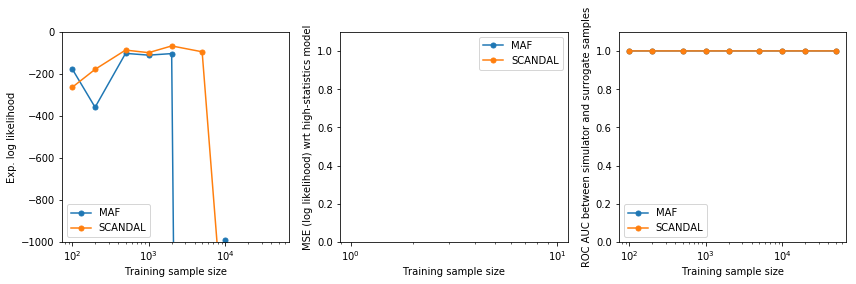

In [46]:
fig = plt.figure(figsize=(12,4))



ax = plt.subplot(1,3,1)

for m, method in enumerate(method_labels):
    plt.plot(sample_sizes, expected_log_likelihoods[m],
             lw=1.5, ls='-', marker='o', ms=5.,
             label=method)
    
    plt.legend()
    
    plt.xlabel('Training sample size')
    plt.ylabel('Exp. log likelihood')
    plt.ylim(-1000.,0.)
    ax.set_xscale("log", nonposx='clip')



ax = plt.subplot(1,3,2)

for m, method in enumerate(method_labels):
    plt.plot(sample_sizes, log_likelihood_mses[m],
             lw=1.5, ls='-', marker='o', ms=5.,
             label=method)
    
    plt.legend()
    
    plt.xlabel('Training sample size')
    plt.ylabel('MSE (log likelihood) wrt high-statistics model')
    plt.ylim(0.,1.1)
    ax.set_xscale("log", nonposx='clip')



ax = plt.subplot(1,3,3)

for m, method in enumerate(method_labels):
    plt.plot(sample_sizes, roc_aucs[m],
             lw=1.5, ls='-', marker='o', ms=5.,
             label=method)
    
    plt.legend()
    
    plt.xlabel('Training sample size')
    plt.ylabel('ROC AUC between simulator and surrogate samples')
    plt.ylim(0.,1.1)
    ax.set_xscale("log", nonposx='clip')
    
    

plt.tight_layout()
plt.show()
